Imports

In [3]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from pandas.plotting import scatter_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Ploteo y muetra de las primeras filasd del dataset

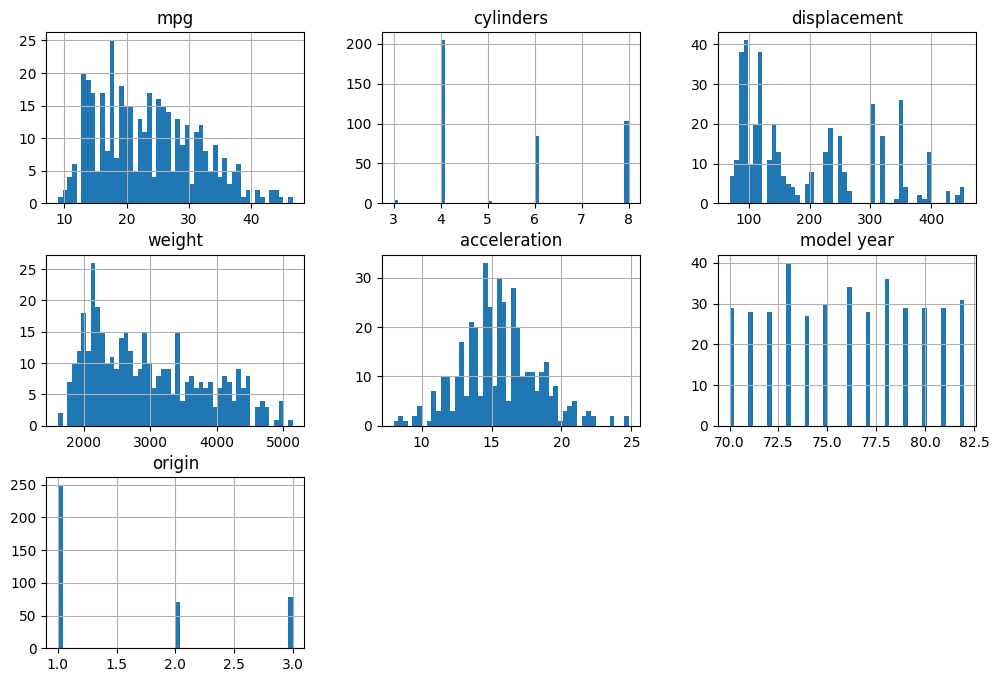

    mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  
Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name'],
      dtype='object')


In [4]:
carsConsume = pd.read_csv(Path("Datasets/auto-mpg[1].csv"))
carsConsume.hist(bins=50, figsize=(12,8))
plt.show()
print(carsConsume.head())
print(carsConsume.columns)

Sanitización de los datos

In [5]:
# Reemplazar "?" por NaN y convertir horsepower a numérico
carsConsume["horsepower"].replace("?", np.nan, inplace=True)
carsConsume["horsepower"] = carsConsume["horsepower"].astype(float)

# Eliminar filas con valores faltantes
carsConsume = carsConsume.dropna()

print(carsConsume.info())


<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB
None


/tmp/ipykernel_283389/3608989371.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  carsConsume["horsepower"].replace("?", np.nan, inplace=True)


Definición de variables

In [6]:
y = carsConsume["mpg"]
X = carsConsume.drop(columns=["mpg", "car name"], errors='ignore')

Muestreo Estratificado

In [7]:
train_carsConsume, test_carsConsume = train_test_split(carsConsume,test_size=0.2, stratify=carsConsume["cylinders"], random_state=42)

X_train = train_carsConsume.drop(columns=["mpg", "car name"], errors='ignore')
y_train = train_carsConsume["mpg"]

X_test = test_carsConsume.drop(columns=["mpg", "car name"], errors='ignore')
y_test = test_carsConsume["mpg"]

Ploteos de seguimiento

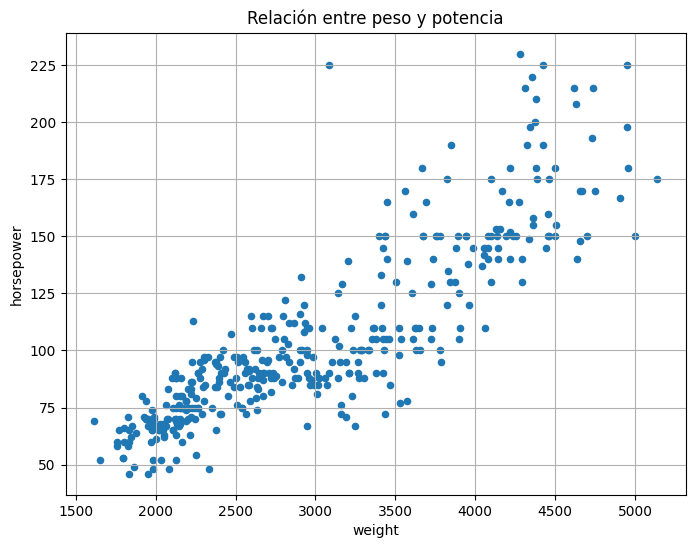

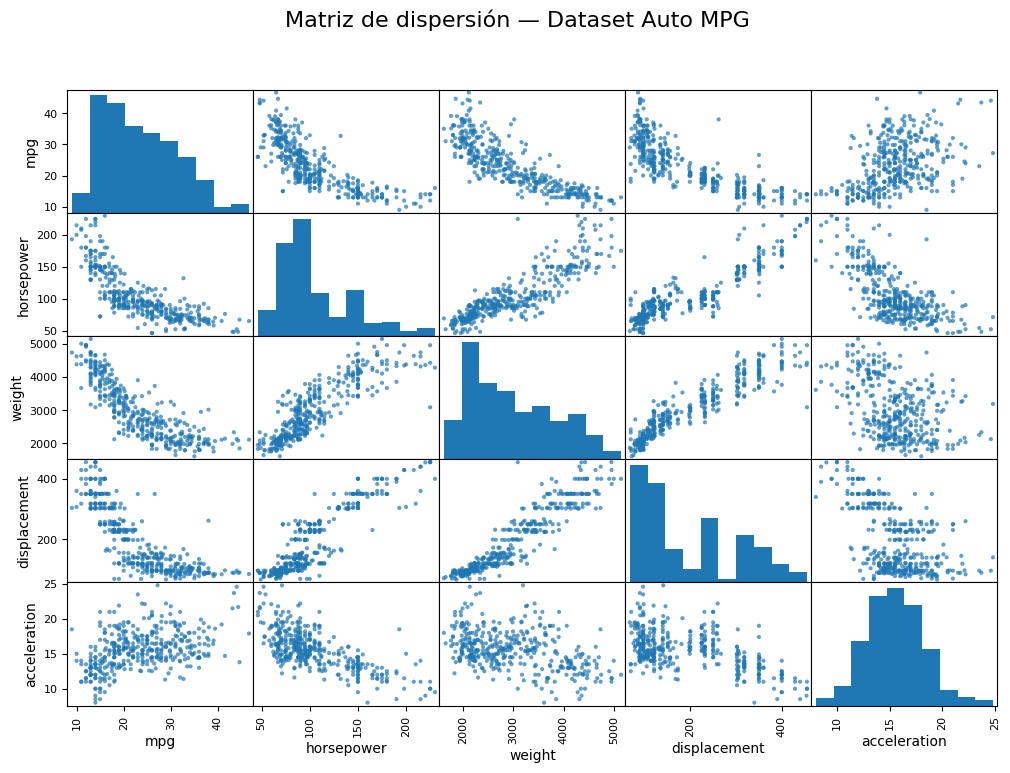

In [8]:
carsConsume.plot(kind="scatter", x="weight", y="horsepower", grid=True, figsize=(8, 6))
plt.title("Relación entre peso y potencia")
plt.show()

attributes = ["mpg", "horsepower", "weight", "displacement", "acceleration"]
scatter_matrix(carsConsume[attributes], figsize=(12, 8), alpha=0.7, diagonal='hist')
plt.suptitle("Matriz de dispersión — Dataset Auto MPG", fontsize=16)
plt.show()

Derivando nuevas características

In [9]:
# Relación potencia/peso — eficiencia del motor
carsConsume["power_weight_ratio"] = carsConsume["horsepower"] / carsConsume["weight"]

# Relación cilindrada/peso — mide "grandeza del motor relativo al tamaño del auto"
carsConsume["displacement_per_weight"] = carsConsume["displacement"] / carsConsume["weight"]

# Relación aceleración/potencia — qué tan rápido acelera por caballo de fuerza
carsConsume["acceleration_per_hp"] = carsConsume["acceleration"] / carsConsume["horsepower"]

corr_matrix = carsConsume.corr(numeric_only=True)

# Ordenar correlaciones con respecto a 'mpg'
print(corr_matrix["mpg"].sort_values(ascending=False))

median_hp = carsConsume["horsepower"].median()
carsConsume["horsepower"].fillna(median_hp, inplace=True)


mpg                        1.000000
acceleration_per_hp        0.710556
model year                 0.580541
origin                     0.565209
acceleration               0.423329
power_weight_ratio        -0.269699
displacement_per_weight   -0.715076
cylinders                 -0.777618
horsepower                -0.778427
displacement              -0.805127
weight                    -0.832244
Name: mpg, dtype: float64


/tmp/ipykernel_283389/1915499466.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  carsConsume["horsepower"].fillna(median_hp, inplace=True)


Definición de atributos numéricos y categóricos

In [10]:
num_attribs = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"]
cat_attribs = ["origin"]

Crear pipelines y convinarlos con ColumnTransformer

In [11]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([("num", num_pipeline, num_attribs),("cat", cat_pipeline, cat_attribs)])

Procesamiento del dataset

In [12]:
set_config(display='diagram')  # Muestra el pipeline visualmente si estás en notebook
carsConsume_prepared = preprocessing.fit_transform(carsConsume)

print("Shape del dataset procesado:", carsConsume_prepared.shape)

Shape del dataset procesado: (392, 9)


Modelo de RL

In [13]:
X_train_prepared = preprocessing.fit_transform(X_train)
X_test_prepared = preprocessing.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)
y_pred = lin_reg.predict(X_test_prepared)

print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

carsConsume_predictions = lin_reg.predict(X_test_prepared)
print("Primeras 5 predicciones:", carsConsume_predictions[:5].round(1))
print("Valores reales:", y_test.iloc[:5].values)

lin_mse = mean_squared_error(y_test, carsConsume_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Linear Regression RMSE:", lin_rmse)

R²: 0.831
RMSE: 3.32
Primeras 5 predicciones: [34.3 26.6 26.3 34.8 17.8]
Valores reales: [38.1 32.7 26.  37.  19. ]
Linear Regression RMSE: 3.319837023082704
